# <b>Classification of Covid Infection Based on Chest X-Ray Images</b>
### <b>Table of Contents</b> <a id="table-contents"></a>
This is the milestone 4 of the CS109B class during Spring 2024 with members Xinyu Chen, Adele Collin, Chuck Lin, Kay Wu (Group #22). 

*Note that the internal links of the table of contents work in Jupyter notebook, but VSCode and Google Colab may have compatibility issues.*
1. [Problem Statement](#problem_statement)
2. [Data Preprocessing](#data_preprocessing)
3. [EDA (exploratory data analysis)](#eda)
4. [Baseline Model Selection, Justification, With Results Interpretation And Analysis](#baseline_model)
5. [Final Model Pipeline Setup](final_model)

<a id="problem_statement"></a>
# 1. Problem Statement

<div style="background: #f5f5dc; border: thin solid black; padding: 5px">

The covid pandemic from 2019 to 2023 caused massive injuries and death, public health and government expenditures, and severe market loss and societal fluctuations. In fact, within 2024 where covid has officially been announced to end, according to CDC there were still 7 million hospitalizations due to covid to date ([accessed April 2024 from CDC](https://covid.cdc.gov/covid-data-tracker/#datatracker-home)). Within the health system, the vast number of population impacted by the virus constantly overloaded the hospistals. The challenges presented by covid include but are not limited to the shortage in medical supplies and resource allocation depending on condition severity, and overwhelmed medical staff. Overall the resources were limited for the patients impacted and often caused delay in treatment with consequences that could have been avoided. A machine learning model that is able to preliminarily screen chest x rays for patients in identification of covid infections would be beneficial to addressing the problem, and here we propose to test the performance of such a model. 

Based on the EDA, we have discovered certain features of the datasets, such as the relatively stable image quality across datasets, different labels and random shifts across datasets, and undocumented underlying concurrent conditions within the data. This makes the dataset noisy and presents a challenge to the machine learning model. Can signs of covid-19 in x-ray scans be identified using machine learning approaches, to predict whether a patient has covid or not, with noisy image sets (e.g. patients have none or a variety of concurrent conditions other than covid, image rotation, position of patient taking the x ray, e.t.c.)?

<a id="data_preprocessing"></a>
# 2. Data Preprocessing

<div style="background: #f5f5dc; border: thin solid black; padding: 5px">

Detail the feature engineering process, including transformations, encoding, or selection techniques, with justifications rooted in EDA.


In [9]:
################################################################################
# LOAD THE DATA
################################################################################
##For local loading:
root = str(os.path.dirname(os.path.realpath('baseline_models.ipynb')))
root = root[1:] + '/'

br_path = '/' +os.path.join(root, "Data/Brixia/Brixia images size 224 arrays.npy")
df_brixia = np.load(br_path)

nih_path = '/' + os.path.join(root,"Data/NIHCXR/image1/NIHCXR images size 224 arrays.npy")
df_nihcxr = np.load(nih_path)

co_path_1 = '/' + os.path.join(root,"Data/COVIDGR_1.0/COVID Positive Array 224.npy")
co_path_2 = '/' + os.path.join(root,"Data/COVIDGR_1.0/COVID Negative Array 224.npy")
df_covidgr_positive = np.load(co_path_1)
df_covidgr_negative = np.load(co_path_2)


##For cloud loading:
#df_brixia = np.load("Data/Brixia/Brixia images size 224 arrays.npy")
#df_nihcxr = np.load("Data/NIHCXR/NIHCXR images size 224 arrays.npy")
#df_covidgr_positive = np.load("Data/COVIDGR_1.0/COVID Positive Array 224.npy")
#df_covidgr_negative = np.load("Data/COVIDGR_1.0/COVID Negative Array 224.npy")

In [ ]:
################################################################################
# PROCESS THE DATA
################################################################################
#Training and Validation data
X_train = np.vstack((df_brixia, df_nihcxr))
y_train = np.concatenate((np.ones(df_brixia.shape[0]), np.zeros(df_nihcxr.shape[0])))

X_test = np.vstack((df_covidgr_positive, df_covidgr_negative))
y_test = np.concatenate((np.ones(df_covidgr_positive.shape[0]), np.zeros(df_covidgr_negative.shape[0])))

<a id="eda"></a>
# 3. EDA (exploratory data analysis)

<div style="background: #f5f5dc; border: thin solid black; padding: 5px">

Below we show the exploratory data analysis for three datasets used in this project, consisting of the brixia dataset for positive training samples, the nihcxr for negative training samples, and covidgr for validation with balanced positive and negative samples. 

The first dataset, the Brixia Score Covid19 Dataset, curated by ASST Spedali Civili di Brescia, comprises 4,707 chest X-ray (CXR) images obtained from sub-intensive and intensive care units over a specific period from March 4th to April 4th, 2020, notably coinciding with the peak of the COVID-19 pandemic. Brixia was acquired through both computed radiography (CR) and digital radiography (DX) modalities, encompassing both anterior-posterior (AP) and posterior-anterior (PA) projections.

The second dataset, the NIH Chest X-ray Dataset, consists of 112,120 frontal-view X-ray images extracted from 30,805 individual patients, and annotated with fourteen distinct thoracic pathologies derived from radiological reports. This dataset contained covid negative samples but also indicated other concurrent conditions, which this information were not contained in the other two datasets.

Lastly, the COVIDGR-1.0 dataset, developed through collaboration with specialists from Hospital Universitario San Cecilio, Spain, comprises of 852 anonymized CXR images categorized into positive and negative instances based on the results of COVID-19 tests conducted via reverse transcription-polymerase chain reaction (RT-PCR) within 24 hours of image acquisition. Consistently captured in the posterior-anterior aspect, these images are classified according to severity levels and accompanied by demographic attributes, including gender distributions, for each identifiable class.

The three datasets combined add up to over 100GB of data, and while we are still performing data compression, we sampled a subset of the two training datasets for preliminary data analysis and modeling. For EDA we performed the image intensity and pixel intensity calcualtion to examine the quality of the images, and found the image quality to be relatively consistent across the datasets. However, by sampling a few images with the highest and lowest image intensity we identified some room of improvements for preprocessing. By resizing and squaring the images to 224x224, some smaller images got padded with 0, some narrower images got compressed or rotated. Additionally, the graphical labelling such as the letters indicating position of the patient when the x-ray was taken, varies in the datasets. This indicates the noisiness of the data and we will address it with further preprocessing, distribution shift, and by utilizing transfer learning models to indirectly improve the performance of the model on nonhomogeneous datasets. We also looked at the bias in demographics. The validation set didn't have any demographics information provided, but for the two training sets, both have the mean age distribution centered around 60 years old and have more male patients, which may present bias in the model and prevent generalization.

In [2]:
################################################################################
# IMPORT LIBRARIES
################################################################################
import os
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Input, GaussianNoise, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adagrad, Adadelta, Adamax

2024-04-24 22:00:27.830529: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-24 22:00:27.876317: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 22:00:27.876357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 22:00:27.877457: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-24 22:00:27.884812: I tensorflow/core/platform/cpu_feature_guar

In [2]:
################################################################################
# HELPER: BASIC
################################################################################
def sample_dim_type(data_name, df):
    print(f"======================{data_name}==========================")
    print(f"\t number of samples in {data_name}: ", df.shape[0])
    # Image dimension 
    print("\t image dimension (height, width, channel): ", df.shape[1:])
    # Image data type
    print("\t image data type: ", df.dtype)

In [11]:
################################################################################
# HELPER: IMAGE INTENSITY
################################################################################
def image_intensity(data_name, df):
    # Average image intensity (compare between samples)
    print(f"======================{data_name}==========================")
    print("\t average image intensity: ", np.mean(np.mean(df, axis=(1,2,3)))) #== np.mean(df_train)
    # Maximum image intensity 
    max_intensity= np.max(np.mean(df, axis=(1,2,3)))
    print("\t maximum image intensity: ", max_intensity)
    # Minimum image intensity
    min_intensity = np.min(np.mean(df, axis=(1,2,3)))
    print("\t minimum image intensity: ", min_intensity)
    ## Stadard deviation of image intensity
    print("\t standard of image intensity: ", np.std(np.mean(df, axis=(1,2,3))))

    # Visualize the max and min intensity images -- can we see any visual difference?
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    axs = axs.flatten()
    axs[0].imshow(df[np.argmax(np.mean(df, axis=(1,2,3))), :, :,:], cmap='gray')
    axs[0].set_title("image with maximum image intensity")
    axs[1].imshow(df[np.argmin(np.mean(df, axis=(1,2,3))), :, :,:], cmap='gray')
    axs[1].set_title("image with minimum image intensity")

    # Create a histogram of the pixel intensity
    plt.figure(figsize=(10, 5))
    plt.hist(df.ravel(), bins=256, color='blue', alpha=0.4)
    #plt.legend(loc='upper right')
    plt.xlabel('Intensity Value')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Pixel Intensity in {data_name}')
    plt.show()

    # Create a histogram of the image intensity
    plt.figure(figsize=(10, 5))
    plt.hist(np.mean(df, axis=(1,2,3)), bins=256, color='blue', alpha=0.4)
    #plt.legend(loc='upper right')
    plt.xlabel('Intensity Value')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Image Intensity in {data_name}')
    plt.show()
    print(f"with min intensity of {min_intensity} and max intensity of {max_intensity}, \n there are no outliers in this dataset")

======================brixia==========================
	 number of samples in brixia:  469
	 image dimension (height, width, channel):  (224, 224, 1)
	 image data type:  float32
======================brixia==========================
	 average image intensity:  0.53036904
	 maximum image intensity:  0.69281775
	 minimum image intensity:  0.28426707
	 standard of image intensity:  0.07222104


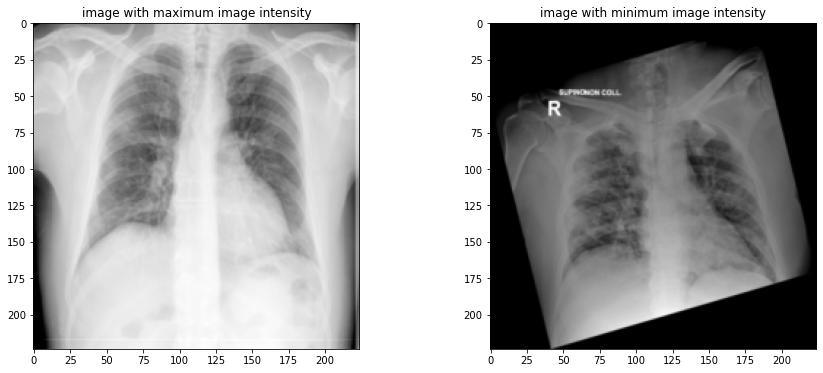

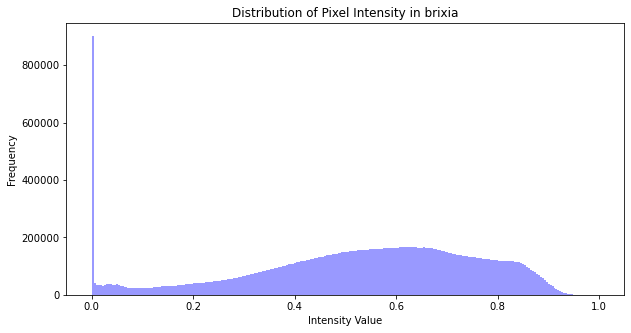

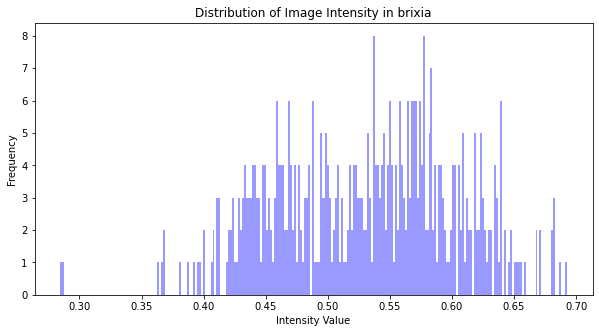

with min intensity of 0.2842670679092407 and max intensity of 0.692817747592926, 
 there are no outliers in this dataset
                               min         max          mean           std
StudyDate               20200304.0  20200409.0  2.020033e+07     32.166845
Columns                     2019.0      3376.0  2.893871e+03    152.103555
Rows                        1056.0      3050.0  2.405939e+03    142.821628
BrixiaScore                    0.0    333333.0  1.021193e+05  99594.274301
BrixiaScoreGlobal              0.0        18.0  8.301171e+00      4.238625
ConsensusTestset               0.0         1.0  3.194888e-02      0.175883
AgeAtStudyDateFiveYear         1.0        19.0  1.247668e+01      2.723331


Text(0.5, 1.0, 'distribution of photometric interpretation in the dataset')

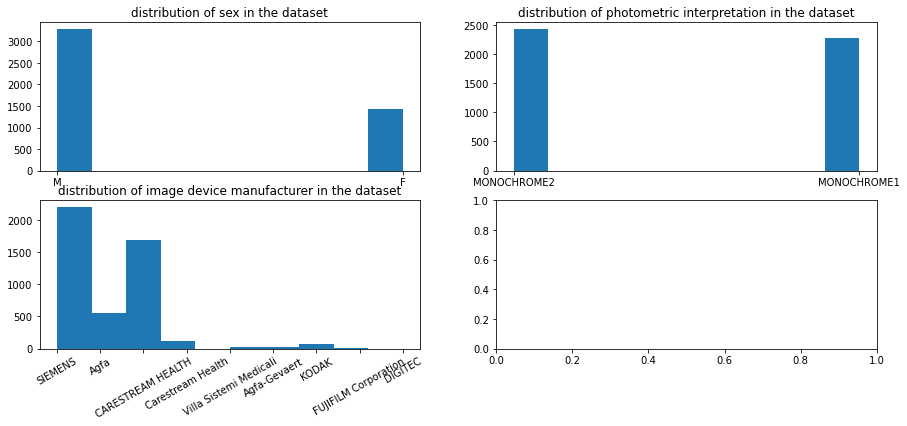

In [26]:
################################################################################
# BRIXIA (positive training)
################################################################################
#run helper functions
sample_dim_type("brixia", df_brixia)
image_intensity("brixia", df_brixia)

## relationship between variables, meta data
#numerical data
metadata_path = '/' + os.path.join(root,"Data/Brixia/Brixia_metadata_global_v2.csv")
df_metadata = pd.read_csv(metadata_path, delimiter=";")
print(df_metadata.describe().transpose()[["min", "max", "mean", "std"]])

#categorical data
fig, axs = plt.subplots(2, 2, figsize=(15, 6))
axs = axs.flatten()
axs[0].hist(df_metadata['Sex'])
axs[0].set_title("distribution of sex in the dataset")
axs[2].hist(df_metadata['Manufacturer'])
axs[2].tick_params(axis="x", rotation=30)
axs[2].set_title("distribution of image device manufacturer in the dataset")
axs[1].hist(df_metadata['PhotometricInterpretation'])
axs[1].set_title("distribution of photometric interpretation in the dataset")

======================nihcxr==========================
	 number of samples in nihcxr:  500
	 image dimension (height, width, channel):  (224, 224, 1)
	 image data type:  float32
======================nihcxr==========================
	 average image intensity:  0.5158608
	 maximum image intensity:  0.74893934
	 minimum image intensity:  0.3004221
	 standard of image intensity:  0.09409551


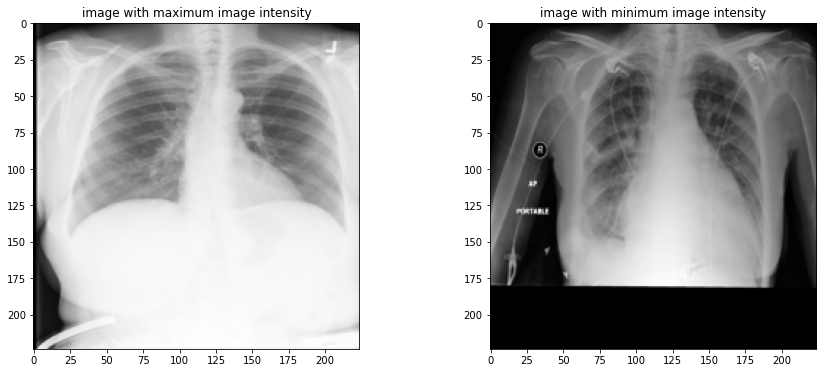

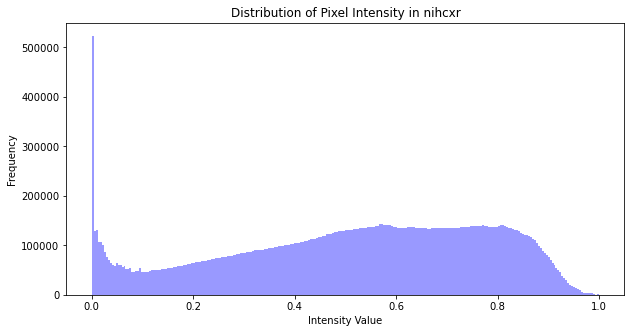

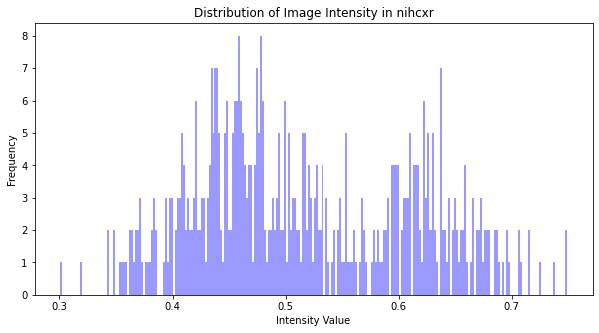

with min intensity of 0.3004221022129059 and max intensity of 0.7489393353462219, 
 there are no outliers in this dataset


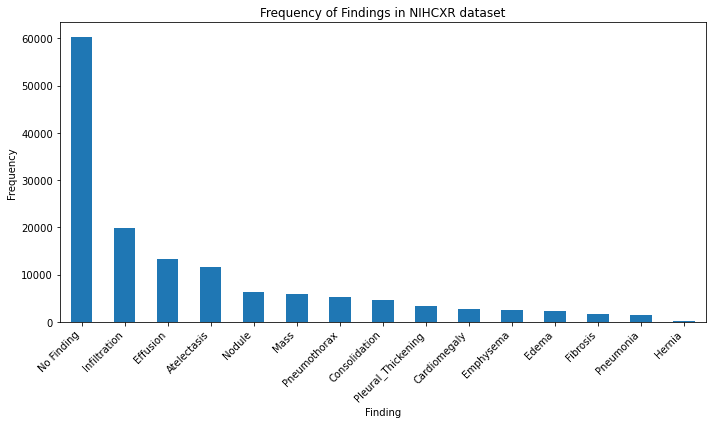

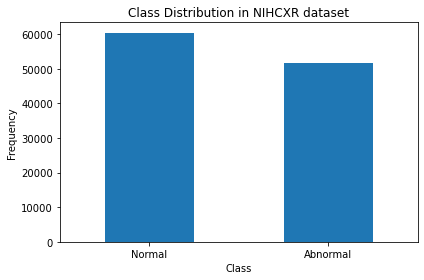

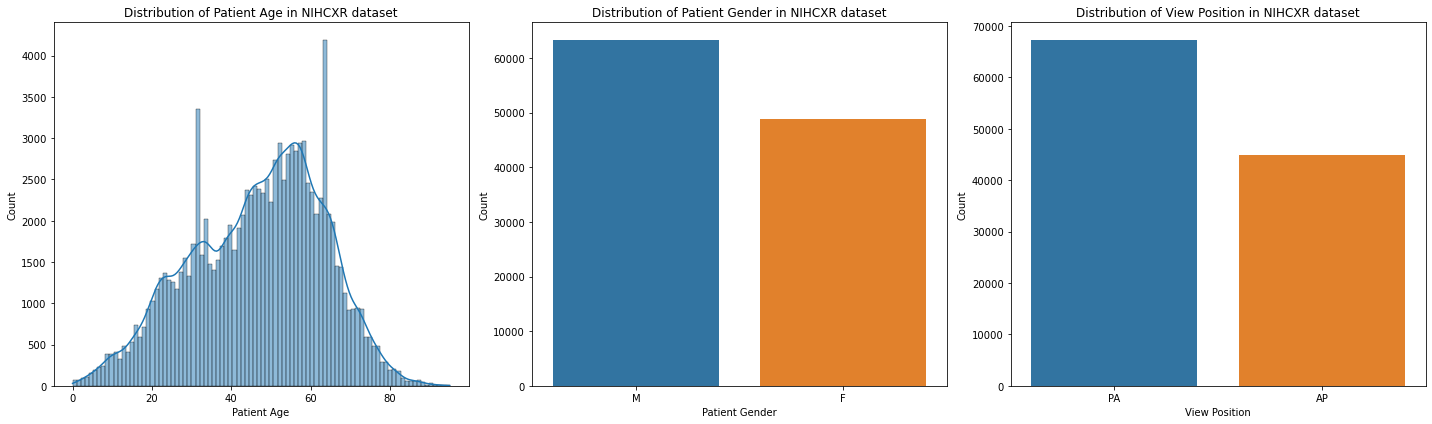

In [27]:
################################################################################
# NIHCXR (negative training)
################################################################################
#run helper functions
sample_dim_type("nihcxr", df_nihcxr)
image_intensity("nihcxr", df_nihcxr)

# Split values in the 'Finding Labels' column by '|'
csv_path = '/' + os.path.join(root, "Data/NIHCXR/Data_Entry_2017_v2020.csv")
df_labels = pd.read_csv(csv_path)
split_values = df_labels['Finding Labels'].str.split('|')

# Create a list to store all findings
all_findings = []

# Iterate over each row and add the findings to the list
for values in split_values:
    all_findings.extend(values)

# Count the occurrences of each finding
finding_counts = pd.Series(all_findings).value_counts()

# Plot the frequencies of each finding
plt.figure(figsize=(10, 6))
finding_counts.plot(kind='bar')
plt.title('Frequency of Findings in NIHCXR dataset')
plt.xlabel('Finding')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calculate the distribution of normal vs. abnormal cases
class_distribution = df_labels['Finding Labels'].apply(lambda x: 'Normal' if x == 'No Finding' else 'Abnormal').value_counts()

# Plot the class distribution
plt.figure(figsize=(6, 4))
class_distribution.plot(kind='bar')
plt.title('Class Distribution in NIHCXR dataset')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


#demographic distribution (only exists in nihcxr, not the other two datasets)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

# Create count plots or histograms for patient age, patient gender, and view position
sns.histplot(data=df_labels, x='Patient Age', ax=axes[0], kde=True)
axes[0].set_title('Distribution of Patient Age in NIHCXR dataset')
axes[0].set_xlabel('Patient Age')
axes[0].set_ylabel('Count')

sns.countplot(data=df_labels, x='Patient Gender', ax=axes[1])
axes[1].set_title('Distribution of Patient Gender in NIHCXR dataset')
axes[1].set_xlabel('Patient Gender')
axes[1].set_ylabel('Count')

sns.countplot(data=df_labels, x='View Position', ax=axes[2])
axes[2].set_title('Distribution of View Position in NIHCXR dataset')
axes[2].set_xlabel('View Position')
axes[2].set_ylabel('Count')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

======================covidgr-negative==========================
	 number of samples in covidgr-negative:  426
	 image dimension (height, width, channel):  (224, 224, 1)
	 image data type:  float32
======================covidgr-negative==========================
	 average image intensity:  0.52109724
	 maximum image intensity:  0.6609612
	 minimum image intensity:  0.20477296
	 standard of image intensity:  0.0507227


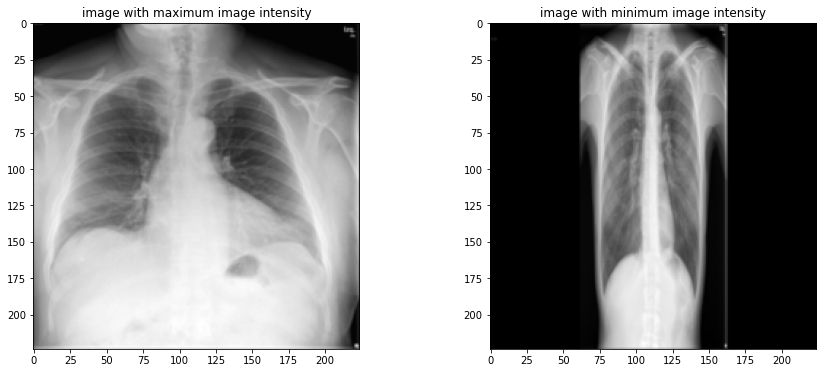

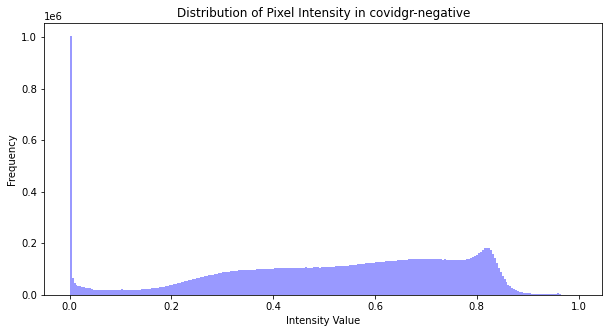

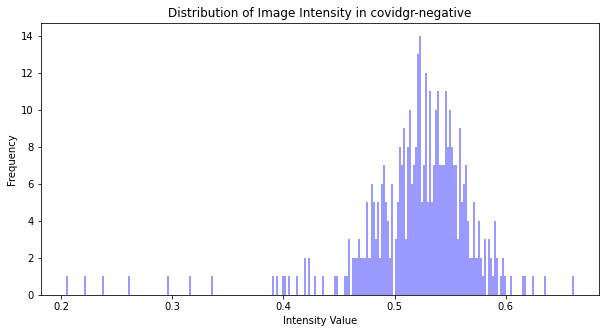

with min intensity of 0.2047729641199112 and max intensity of 0.6609612107276917, 
 there are no outliers in this dataset
======================covidgr-positive==========================
	 number of samples in covidgr-positive:  426
	 image dimension (height, width, channel):  (224, 224, 1)
	 image data type:  float32
======================covidgr-positive==========================
	 average image intensity:  0.53151315
	 maximum image intensity:  0.7555844
	 minimum image intensity:  0.26859397
	 standard of image intensity:  0.05474112


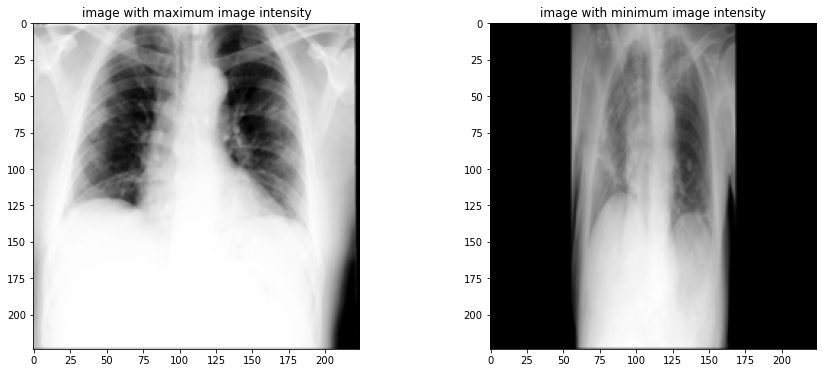

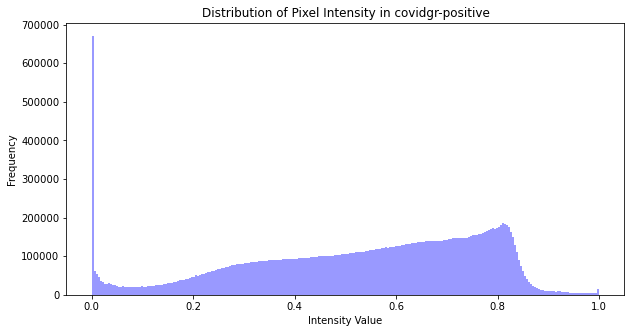

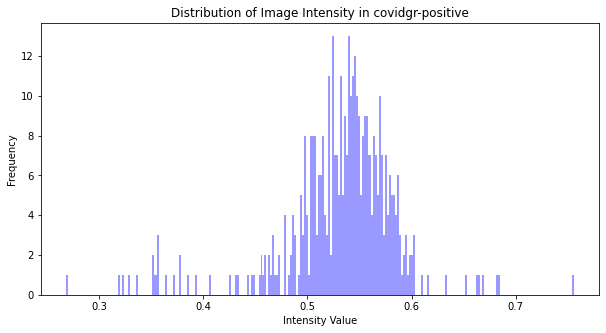

with min intensity of 0.268593966960907 and max intensity of 0.7555844187736511, 
 there are no outliers in this dataset


In [25]:
################################################################################
# COVIDGR (validation)
################################################################################

#run helper functions
sample_dim_type("covidgr-negative", df_covidgr_negative)
image_intensity("covidgr-negative", df_covidgr_negative)
sample_dim_type("covidgr-positive", df_covidgr_positive)
image_intensity("covidgr-positive", df_covidgr_positive)


<a id="baseline_model"></a>
# 4. Baseline Model Selection, Justification, With Results Interpretation And Analysis

<div style="background: #f5f5dc; border: thin solid black; padding: 5px">

Considering the task at hand, a binary classification of covid versus non-covid on chest x-ray images with giant datasets, we decided to use transfer learning. Before the implementation of transfer learning models, we first implemented a naive CNN to see if it is able to learn anything with shallow layers, which if so then we will be able to train more data with limited GPU access. However, the naive CNN proved to be insufficient, thus we moved onto a ResNet50 model as the baseline model. For training the ResNet model, we adopted a gradient of learning rates, starting with high learning rate for the dense layers while freezing all the pretrained layers, then gradually decreasing the learning rate and unfreezing a layer at a time to retrain the model. We started with more layers added to the ResNet structure, however we didn't have enough GPU resources to train any epoch of that model. Thus we simplified the model and tested with different hyperparameters. <b> what hyperparameters?</b> The performance of the model was then evaluated using accuracy and loss. <b>*Present initial results, discussing alignment with expectations and project objectives.</b>  <b>*Assess strengths and weaknesses of the model, proposing improvements for the next iteration.</b>


original requirement:

Explain the choice of your baseline model, considering simplicity, interpretability, and relevance.

Detail the training process, including preprocessing, parameters, and metrics used for evaluation.

Present initial results, discussing alignment with expectations and project objectives.


Analyze the baseline model’s performance, using appropriate metrics and visualizations.

Assess strengths and weaknesses of the model, proposing improvements for the next iteration.

In [9]:
################################################################################
# CNN MODELS (CREATE AND COMPILE)
################################################################################
def create_model(input_shape):
    inp = Input(shape=input_shape)
    x = GaussianNoise(stddev=0.1)(inp)
    x = Conv2D(64, 2, activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(64, 2, activation='relu', padding='same')(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, 2, activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(128, 2, activation='relu', padding='same')(x)
    x = Dropout(0.25)(x)
    x = Conv2D(128, 2, activation='relu', padding='same')(x)
    x = Conv2D(129, 2, activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(256, 2, activation='relu', padding='same')(x)
    x = Dropout(0.25)(x)
    x = Conv2D(256, 2, activation='relu', padding='same')(x)
    x = Conv2D(256, 2, activation='relu', padding='same')(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[inp], outputs=out)
    return model

def compile_and_train_model(model, optimizer, learning_rate, batch_size, X_train, y_train, epochs):
    es = EarlyStopping(monitor='loss', patience=5, verbose=0,
                   mode='auto',restore_best_weights=True)
    opt = optimizer(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[es])
    return history

In [6]:
################################################################################
# PLOTTING HELPERS
################################################################################
def plot_helper_accuracy(model, title=None, ax=None, label_train='train', label_val='val'):
    if ax is None:
        ax = plt.gca()
    ax.plot(model.history.history['accuracy'], label='train')
    ax.plot(model.history.history['val_accuracy'], label='validation')
    best_val = np.argmax(model.history.history['val_accuracy'])
    best_val_value = np.nanmax(model.history.history['val_accuracy'])
    ax.axvline(np.argmax(model.history.history['val_accuracy']),
                    c='k', ls='--',
                    label=f'best val accuracy: {best_val_value:.2f}')
    ax.set_xlabel('epoch')
    ax.set_ylabel('accuracy')
    ax.set_title(title)
    ax.legend(loc='lower right');

def plot_helper_loss(model, title=None, ax=None, label_train='train', label_val='val'):
    if ax is None:
        ax = plt.gca()
    ax.plot(model.history.history['loss'], label=label_train)
    ax.plot(model.history.history['val_loss'], label=label_val)
    best_val = np.argmin(model.history.history['val_loss'])
    best_val_value = np.nanmin(model.history.history['val_loss'])
    ax.axvline(np.argmin(model.history.history['val_loss']),
                    c='k', ls='--',
                    label=f'best val loss: {best_val_value:.2f}')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.set_title(title)
    ax.legend(loc='lower right');

def plot_helper_accuracy_models(history, title=None, ax=None, label_train='train', label_val='val'):
    if ax is None:
        ax = plt.gca()
    ax.plot(history.history['accuracy'], label='train')
    ax.plot(history.history['val_accuracy'], label='validation')
    best_val = np.argmax(history.history['val_accuracy'])
    best_val_value = np.nanmax(history.history['val_accuracy'])
    ax.axvline(np.argmax(history.history['val_accuracy']),
                    c='k', ls='--',
                    label=f'best val accuracy: {best_val_value:.2f}')
    ax.set_xlabel('epoch')
    ax.set_ylabel('accuracy')
    ax.set_title(title)
    ax.legend(loc='lower right')

def plot_helper_loss_models(history, title=None, ax=None, label_train='train', label_val='val'):
    if ax is None:
        ax = plt.gca()
    ax.plot(history.history['loss'], label=label_train)
    ax.plot(history.history['val_loss'], label=label_val)
    best_val = np.argmin(history.history['val_loss'])
    best_val_value = np.nanmin(history.history['val_loss'])
    ax.axvline(np.argmin(history.history['val_loss']),
                    c='k', ls='--',
                    label=f'best val loss: {best_val_value:.2f}')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.set_title(title)
    ax.legend(loc='upper right')

In [10]:
################################################################################
# CNN MODELS (hyperparameter tuning: learning rate)
################################################################################
input_shape = X_train.shape[1:]

# Test learning rates
learning_rates = [0.0001, 0.001, 0.01, 0.05, 0.1] 
model_list_lr = []
history_list_lr = []
for lr in learning_rates:
    model_lr = create_model(input_shape)
    history = compile_and_train_model(model_lr, tf.keras.optimizers.Adam, lr, 32, X_train, y_train, 20)
    model_list_lr.append(model_lr)
    history_list_lr.append(history)

2024-04-24 22:02:34.494135: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-24 22:02:34.548038: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-24 22:02:34.551177: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/20


2024-04-24 22:02:37.596231: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-24 22:02:37.865003: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-04-24 22:02:38.276951: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-24 22:02:38.964357: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-24 22:02:40.729336: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc844951e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-24 22:02:40.729370: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capabili

25/25 [==============================] - 16s 301ms/step - loss: 0.6702 - accuracy: 0.6065 - val_loss: 0.7787 - val_accuracy: 0.0000e+00
Epoch 2/20
25/25 [==============================] - 6s 233ms/step - loss: 0.6675 - accuracy: 0.6065 - val_loss: 0.7461 - val_accuracy: 0.0000e+00
Epoch 3/20
25/25 [==============================] - 6s 233ms/step - loss: 0.6583 - accuracy: 0.6142 - val_loss: 0.7688 - val_accuracy: 0.0103
Epoch 4/20
25/25 [==============================] - 6s 234ms/step - loss: 0.6472 - accuracy: 0.6594 - val_loss: 0.7809 - val_accuracy: 0.1546
Epoch 5/20
25/25 [==============================] - 6s 234ms/step - loss: 0.6392 - accuracy: 0.6671 - val_loss: 0.6500 - val_accuracy: 0.9536
Epoch 6/20
25/25 [==============================] - 6s 234ms/step - loss: 0.6289 - accuracy: 0.6645 - val_loss: 0.7987 - val_accuracy: 0.2938
Epoch 7/20
25/25 [==============================] - 6s 235ms/step - loss: 0.5934 - accuracy: 0.7110 - val_loss: 0.7258 - val_accuracy: 0.4691
Epoch 8/

2024-04-24 22:04:45.945813: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


25/25 [==============================] - 9s 245ms/step - loss: 0.7218 - accuracy: 0.5871 - val_loss: 0.7206 - val_accuracy: 0.0000e+00
Epoch 2/20
25/25 [==============================] - 6s 228ms/step - loss: 0.6739 - accuracy: 0.6052 - val_loss: 0.9404 - val_accuracy: 0.0000e+00
Epoch 3/20
25/25 [==============================] - 6s 226ms/step - loss: 0.6748 - accuracy: 0.6052 - val_loss: 0.8963 - val_accuracy: 0.0000e+00
Epoch 4/20
25/25 [==============================] - 6s 228ms/step - loss: 0.6722 - accuracy: 0.6052 - val_loss: 0.9184 - val_accuracy: 0.0000e+00
Epoch 5/20
25/25 [==============================] - 6s 226ms/step - loss: 0.6748 - accuracy: 0.6052 - val_loss: 0.9011 - val_accuracy: 0.0000e+00
Epoch 6/20
25/25 [==============================] - 6s 226ms/step - loss: 0.6746 - accuracy: 0.6052 - val_loss: 0.8498 - val_accuracy: 0.0000e+00
Epoch 7/20
25/25 [==============================] - 6s 227ms/step - loss: 0.6753 - accuracy: 0.6052 - val_loss: 0.9064 - val_accuracy: 

2024-04-24 22:06:10.526483: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


25/25 [==============================] - 9s 232ms/step - loss: 39.3787 - accuracy: 0.5871 - val_loss: 0.9709 - val_accuracy: 0.0000e+00
Epoch 2/20
25/25 [==============================] - 5s 212ms/step - loss: 0.6760 - accuracy: 0.6052 - val_loss: 0.8227 - val_accuracy: 0.0000e+00
Epoch 3/20
25/25 [==============================] - 5s 212ms/step - loss: 0.6747 - accuracy: 0.6052 - val_loss: 0.9220 - val_accuracy: 0.0000e+00
Epoch 4/20
25/25 [==============================] - 5s 210ms/step - loss: 0.6762 - accuracy: 0.6052 - val_loss: 0.8462 - val_accuracy: 0.0000e+00
Epoch 5/20
25/25 [==============================] - 5s 212ms/step - loss: 0.6712 - accuracy: 0.6052 - val_loss: 0.9559 - val_accuracy: 0.0000e+00
Epoch 6/20
25/25 [==============================] - 5s 210ms/step - loss: 0.6787 - accuracy: 0.6052 - val_loss: 0.8701 - val_accuracy: 0.0000e+00
Epoch 7/20
25/25 [==============================] - 5s 210ms/step - loss: 0.6762 - accuracy: 0.6052 - val_loss: 0.8703 - val_accuracy:

2024-04-24 22:07:47.844416: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


25/25 [==============================] - 9s 222ms/step - loss: 1858938240.0000 - accuracy: 0.5703 - val_loss: 0.9977 - val_accuracy: 0.0000e+00
Epoch 2/20
25/25 [==============================] - 5s 207ms/step - loss: 0.6738 - accuracy: 0.6052 - val_loss: 0.7772 - val_accuracy: 0.0000e+00
Epoch 3/20
25/25 [==============================] - 5s 206ms/step - loss: 0.6749 - accuracy: 0.6052 - val_loss: 0.9754 - val_accuracy: 0.0000e+00
Epoch 4/20
25/25 [==============================] - 5s 207ms/step - loss: 0.6717 - accuracy: 0.6052 - val_loss: 0.9304 - val_accuracy: 0.0000e+00
Epoch 5/20
25/25 [==============================] - 5s 206ms/step - loss: 0.6718 - accuracy: 0.6052 - val_loss: 0.9391 - val_accuracy: 0.0000e+00
Epoch 6/20
25/25 [==============================] - 5s 206ms/step - loss: 0.6729 - accuracy: 0.6052 - val_loss: 0.9128 - val_accuracy: 0.0000e+00
Epoch 7/20
25/25 [==============================] - 5s 206ms/step - loss: 0.6728 - accuracy: 0.6052 - val_loss: 0.9449 - val_a

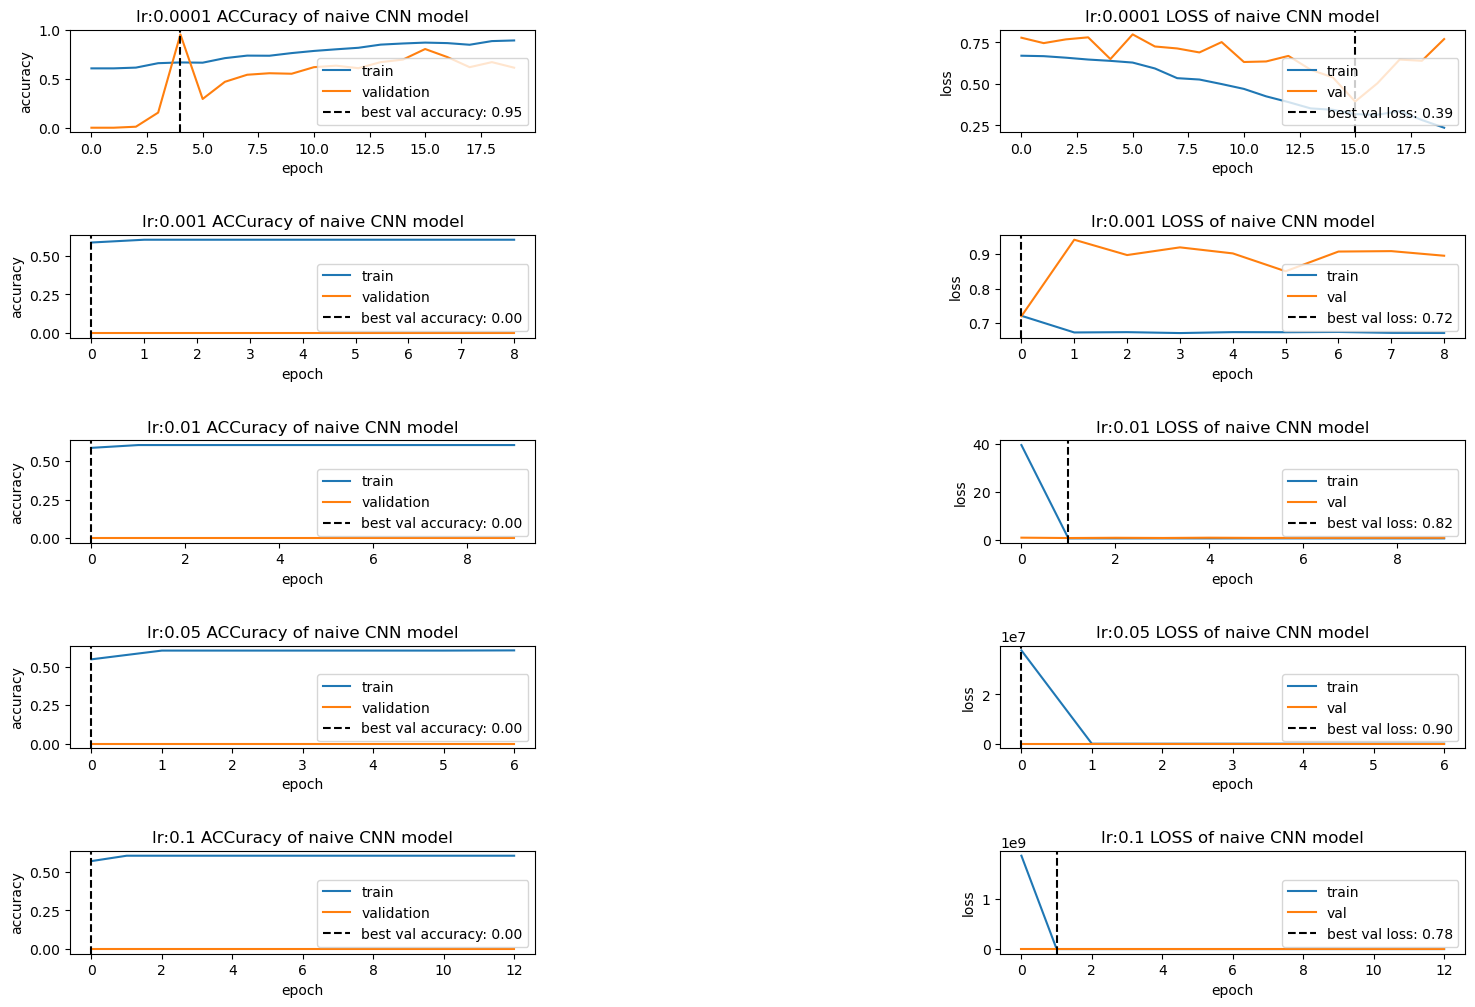

In [12]:
#Plot the results
fig, axs = plt.subplots(5, 2, figsize=(18,12))
axs = axs.flatten()
for i, modl in enumerate(model_list_lr):
    plot_helper_accuracy(modl, 
                         title=f'lr:{learning_rates[i]} ACCuracy of naive CNN model', 
                         ax=axs[i*2])
    plot_helper_loss(modl, 
                     title=f'lr:{learning_rates[i]} LOSS of naive CNN model', 
                     ax=axs[i*2+1])
plt.subplots_adjust(wspace=1, hspace=1)
plt.show()

In [13]:
################################################################################
# CNN MODELS (hyperparameter tuning: batch size)
################################################################################
# Test batch sizes
batch_sizes = [32, 64, 128]
model_list_batch = []
history_list_batch = []
for batch in batch_sizes:
    model_batch = create_model(input_shape)
    history = compile_and_train_model(model_batch, tf.keras.optimizers.Adam, 0.0001, batch, X_train, y_train, 10)
    model_list_batch.append(model_batch)
    history_list_batch.append(history)

Epoch 1/10


2024-04-24 22:10:23.956111: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


25/25 [==============================] - 9s 247ms/step - loss: 0.6836 - accuracy: 0.6026 - val_loss: 0.7989 - val_accuracy: 0.0000e+00
Epoch 2/10
25/25 [==============================] - 6s 233ms/step - loss: 0.6746 - accuracy: 0.6052 - val_loss: 0.7248 - val_accuracy: 0.0000e+00
Epoch 3/10
25/25 [==============================] - 6s 233ms/step - loss: 0.6704 - accuracy: 0.6052 - val_loss: 0.7985 - val_accuracy: 0.0000e+00
Epoch 4/10
25/25 [==============================] - 6s 233ms/step - loss: 0.6665 - accuracy: 0.6052 - val_loss: 0.7629 - val_accuracy: 0.0000e+00
Epoch 5/10
25/25 [==============================] - 6s 234ms/step - loss: 0.6502 - accuracy: 0.6361 - val_loss: 0.8079 - val_accuracy: 0.0052
Epoch 6/10
25/25 [==============================] - 6s 233ms/step - loss: 0.6712 - accuracy: 0.6129 - val_loss: 0.7765 - val_accuracy: 0.0000e+00
Epoch 7/10
25/25 [==============================] - 6s 233ms/step - loss: 0.6531 - accuracy: 0.6581 - val_loss: 0.7349 - val_accuracy: 0.30

2024-04-24 22:11:26.638569: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


13/13 [==============================] - 14s 468ms/step - loss: 0.6767 - accuracy: 0.5987 - val_loss: 0.7360 - val_accuracy: 0.0000e+00
Epoch 2/10
13/13 [==============================] - 6s 441ms/step - loss: 0.6696 - accuracy: 0.6052 - val_loss: 0.7483 - val_accuracy: 0.0000e+00
Epoch 3/10
13/13 [==============================] - 6s 442ms/step - loss: 0.6649 - accuracy: 0.6052 - val_loss: 0.7465 - val_accuracy: 0.0000e+00
Epoch 4/10
13/13 [==============================] - 6s 442ms/step - loss: 0.6614 - accuracy: 0.6103 - val_loss: 0.8603 - val_accuracy: 0.0000e+00
Epoch 5/10
13/13 [==============================] - 6s 440ms/step - loss: 0.6636 - accuracy: 0.6465 - val_loss: 0.7569 - val_accuracy: 0.0825
Epoch 6/10
13/13 [==============================] - 6s 443ms/step - loss: 0.6366 - accuracy: 0.6439 - val_loss: 0.7000 - val_accuracy: 0.4845
Epoch 7/10
13/13 [==============================] - 6s 443ms/step - loss: 0.6265 - accuracy: 0.6735 - val_loss: 0.6931 - val_accuracy: 0.5103


2024-04-24 22:12:32.451458: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/dropout_28/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


7/7 [==============================] - 19s 1s/step - loss: 0.6819 - accuracy: 0.5755 - val_loss: 0.7414 - val_accuracy: 0.0000e+00
Epoch 2/10
7/7 [==============================] - 6s 811ms/step - loss: 0.6760 - accuracy: 0.6052 - val_loss: 0.7370 - val_accuracy: 0.0000e+00
Epoch 3/10
7/7 [==============================] - 6s 812ms/step - loss: 0.6710 - accuracy: 0.6052 - val_loss: 0.7459 - val_accuracy: 0.0000e+00
Epoch 4/10
7/7 [==============================] - 6s 812ms/step - loss: 0.6691 - accuracy: 0.6052 - val_loss: 0.7623 - val_accuracy: 0.0000e+00
Epoch 5/10
7/7 [==============================] - 6s 805ms/step - loss: 0.6733 - accuracy: 0.6052 - val_loss: 0.7378 - val_accuracy: 0.0000e+00
Epoch 6/10
7/7 [==============================] - 6s 807ms/step - loss: 0.6734 - accuracy: 0.6052 - val_loss: 0.7512 - val_accuracy: 0.0000e+00
Epoch 7/10
7/7 [==============================] - 6s 807ms/step - loss: 0.6703 - accuracy: 0.6052 - val_loss: 0.6998 - val_accuracy: 0.0000e+00
Epoch

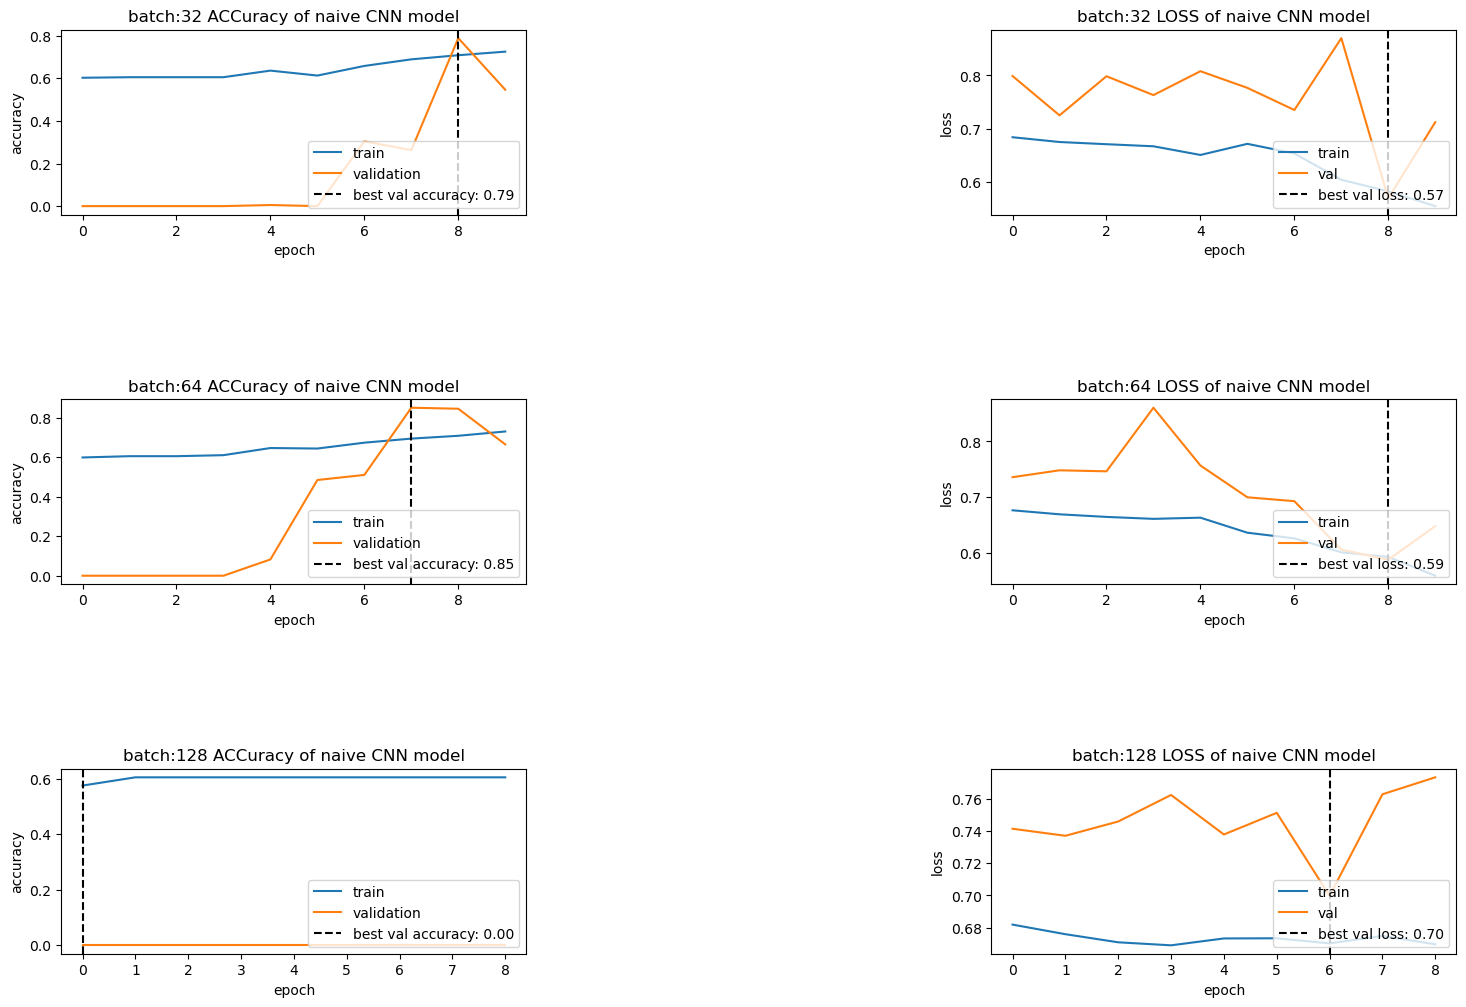

In [14]:
#Plot the results
fig, axs = plt.subplots(3, 2, figsize=(18,12))
axs = axs.flatten()
for i, modl in enumerate(model_list_batch):
    plot_helper_accuracy(modl, 
                         title=f'batch:{batch_sizes[i]} ACCuracy of naive CNN model', 
                         ax=axs[i*2])
    plot_helper_loss(modl, 
                     title=f'batch:{batch_sizes[i]} LOSS of naive CNN model', 
                     ax=axs[i*2+1])
plt.subplots_adjust(wspace=1, hspace=1)
plt.show()


In [118]:
################################################################################
# PROCESs THE DATA (for transfer learning)
################################################################################
# Expand data to from 1 to 3 channels for ResNet50 model
X_train_expand = np.repeat(X_train, 3, -1)
X_test_expand = np.repeat(X_test, 3, -1)

# Split the data
# Train test split, shuffle = T 
X_train_expand_part, X_val, y_train_part, y_val = train_test_split(X_train_expand, y_train, test_size=0.2, shuffle= True, random_state=109)

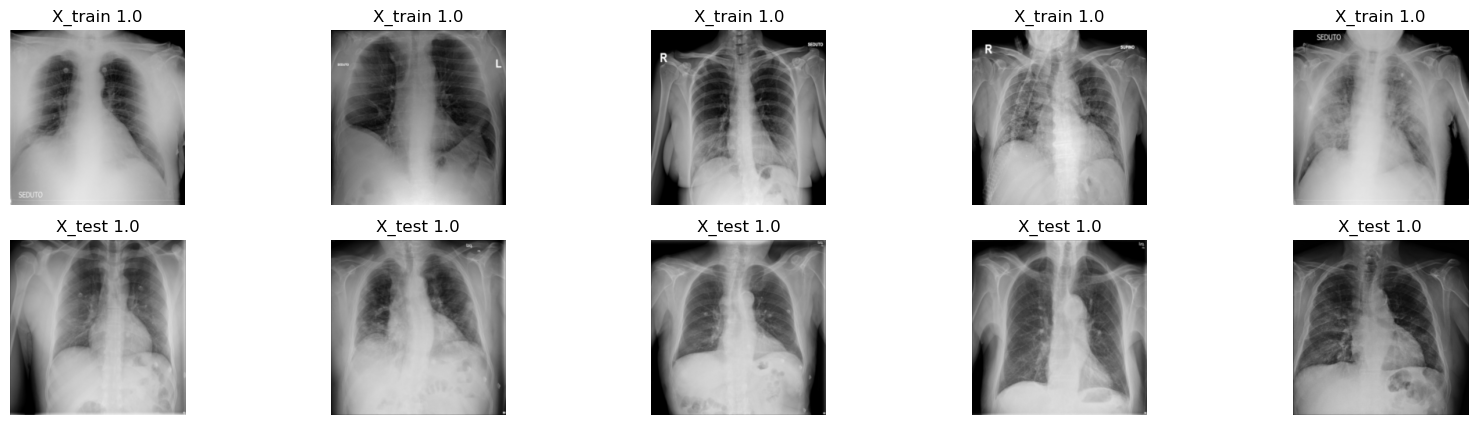

In [89]:
# Show 5 X_train and X_test expand image and its label
fig, axs = plt.subplots(2, 5, figsize=(20, 5))
for i in range(5):
    axs[0, i].imshow(X_train_expand[i])
    axs[0, i].set_title(f'X_train {y_train[i]}')
    axs[0, i].axis('off')
    axs[1, i].imshow(X_test_expand[i])
    axs[1, i].set_title(f'X_test {y_test[i]}')
    axs[1, i].axis('off')
plt.show()

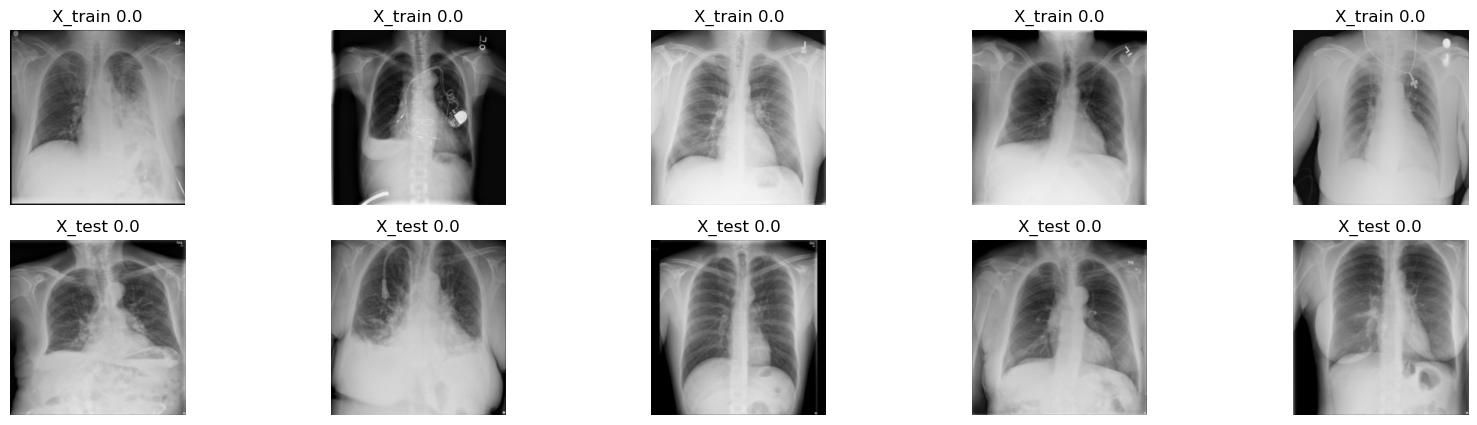

In [92]:
# Show the last 5 X_train and X_test expand image and its label
fig, axs = plt.subplots(2, 5, figsize=(20, 5))
for i in np.arange(1,6,1):
    axs[0, i-1].imshow(X_train_expand[-i])
    axs[0, i-1].set_title(f'X_train {y_train[-i]}')
    axs[0, i-1].axis('off')
    axs[1, i-1].imshow(X_test_expand[-i])
    axs[1, i-1].set_title(f'X_test {y_test[-i]}')
    axs[1, i-1].axis('off')
plt.show()

In [ ]:
################################################################################
# ResNet MODEL (CREATE AND COMPILE)
################################################################################
# Use ResNet50 for transfer learning 
def create_resnet_model(input_shape):
    # Use Imagenet weights
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in base_model.layers:
        # unfreeze the last block of ResNet50
        if layer.name in ['conv5_block3_1_conv', 'conv5_block3_1_bn', 'conv5_block3_2_conv', 'conv5_block3_2_bn', 'conv5_block3_3_conv', 'conv5_block3_3_bn']:
            layer.trainable = True
        else:
            layer.trainable = False
    # Flatten the output of ResNet50 
    x = Flatten()(base_model.output)
    # Dense + Dropout layers 
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    # Binary classification output
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=out)
    return model

# compile the transfer learning model 
def compile_and_train_resnet_model(model, optimizer, learning_rate, batch_size, X_train, y_train, X_test, y_test, epochs):
    es = EarlyStopping(monitor='loss', patience=5, verbose=0,
                   mode='auto',restore_best_weights=True)
    opt = optimizer(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    # print(model.summary())
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=[es])
    return history

In [143]:
################################################################################
# RUN ResNet
################################################################################
# Run the transfer learning model
resnet_model = create_resnet_model(input_shape=X_train_expand.shape[1:])
## Best learning rate = 1e-5 and batch_size = 32 from experimenting 
history_resnet = compile_and_train_resnet_model(model=resnet_model, optimizer=Adam, learning_rate=1e-5, batch_size=32, 
                                                X_train=X_train_expand_part, y_train=y_train_part, X_test=X_val, y_test=y_val, epochs=50) 

Epoch 1/50
25/25 [==============================] - 12s 181ms/step - loss: 0.6971 - accuracy: 0.5665 - val_loss: 0.7111 - val_accuracy: 0.4639
Epoch 2/50
25/25 [==============================] - 3s 120ms/step - loss: 0.5718 - accuracy: 0.6826 - val_loss: 0.7157 - val_accuracy: 0.4691
Epoch 3/50
25/25 [==============================] - 3s 119ms/step - loss: 0.5344 - accuracy: 0.7213 - val_loss: 0.7080 - val_accuracy: 0.4742
Epoch 4/50
25/25 [==============================] - 3s 120ms/step - loss: 0.4553 - accuracy: 0.7806 - val_loss: 0.7322 - val_accuracy: 0.4639
Epoch 5/50
25/25 [==============================] - 3s 115ms/step - loss: 0.4691 - accuracy: 0.7639 - val_loss: 0.7209 - val_accuracy: 0.4691
Epoch 6/50
25/25 [==============================] - 3s 119ms/step - loss: 0.4358 - accuracy: 0.7858 - val_loss: 0.7053 - val_accuracy: 0.4742
Epoch 7/50
25/25 [==============================] - 3s 115ms/step - loss: 0.4769 - accuracy: 0.7639 - val_loss: 0.6538 - val_accuracy: 0.5825
Epoch

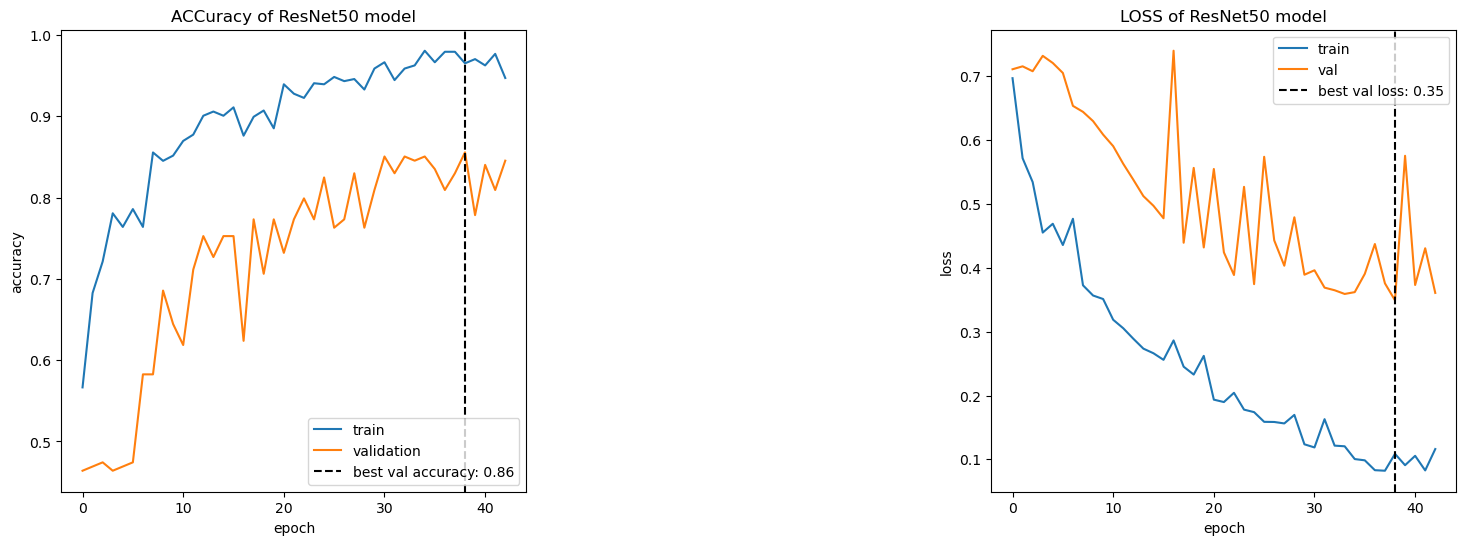

In [144]:
#Plot the results - basic ResNet
fig, axs = plt.subplots(1, 2, figsize=(18,6))
axs = axs.flatten()
plot_helper_accuracy(history_resnet, 
                         title=f'Accuracy of ResNet50 model', 
                         ax=axs[0])
plot_helper_loss(history_resnet,
                        title=f'Loss of ResNet50 model', 
                        ax=axs[1])
plt.subplots_adjust(wspace=1, hspace=1)
plt.show()

Epoch 1/10
25/25 [==============================] - 10s 182ms/step - loss: 1.0184 - accuracy: 0.5329 - val_loss: 0.6919 - val_accuracy: 0.5000
Epoch 2/10
25/25 [==============================] - 3s 119ms/step - loss: 0.6251 - accuracy: 0.6103 - val_loss: 0.6817 - val_accuracy: 0.5412
Epoch 3/10
25/25 [==============================] - 3s 119ms/step - loss: 0.5795 - accuracy: 0.6774 - val_loss: 0.6797 - val_accuracy: 0.6649
Epoch 4/10
25/25 [==============================] - 3s 114ms/step - loss: 0.5955 - accuracy: 0.6439 - val_loss: 0.6864 - val_accuracy: 0.4948
Epoch 5/10
25/25 [==============================] - 3s 114ms/step - loss: 0.5923 - accuracy: 0.5832 - val_loss: 0.6706 - val_accuracy: 0.5361
Epoch 6/10
25/25 [==============================] - 3s 115ms/step - loss: 0.6007 - accuracy: 0.6877 - val_loss: 0.6519 - val_accuracy: 0.6340
Epoch 7/10
25/25 [==============================] - 3s 119ms/step - loss: 0.5042 - accuracy: 0.7342 - val_loss: 0.6369 - val_accuracy: 0.7010
Epoch

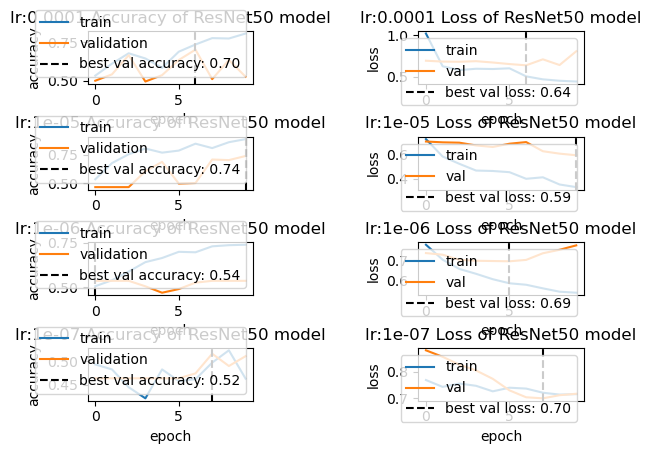

In [135]:
################################################################################
# RUN ResNet (hypeparameter tuning: learning rate)
################################################################################
# Test learning rate 
learning_rates = [1e-4, 1e-5, 1e-6, 1e-7]
model_list_lr = []
history_list_lr = []
for lr in learning_rates:
    model_lr = create_resnet_model(X_train_expand.shape[1:])
    history = compile_and_train_resnet_model(model_lr, Adam, lr, 32, X_train_expand_part, y_train_part, X_val, y_val, 10)
    model_list_lr.append(model_lr)
    history_list_lr.append(history)

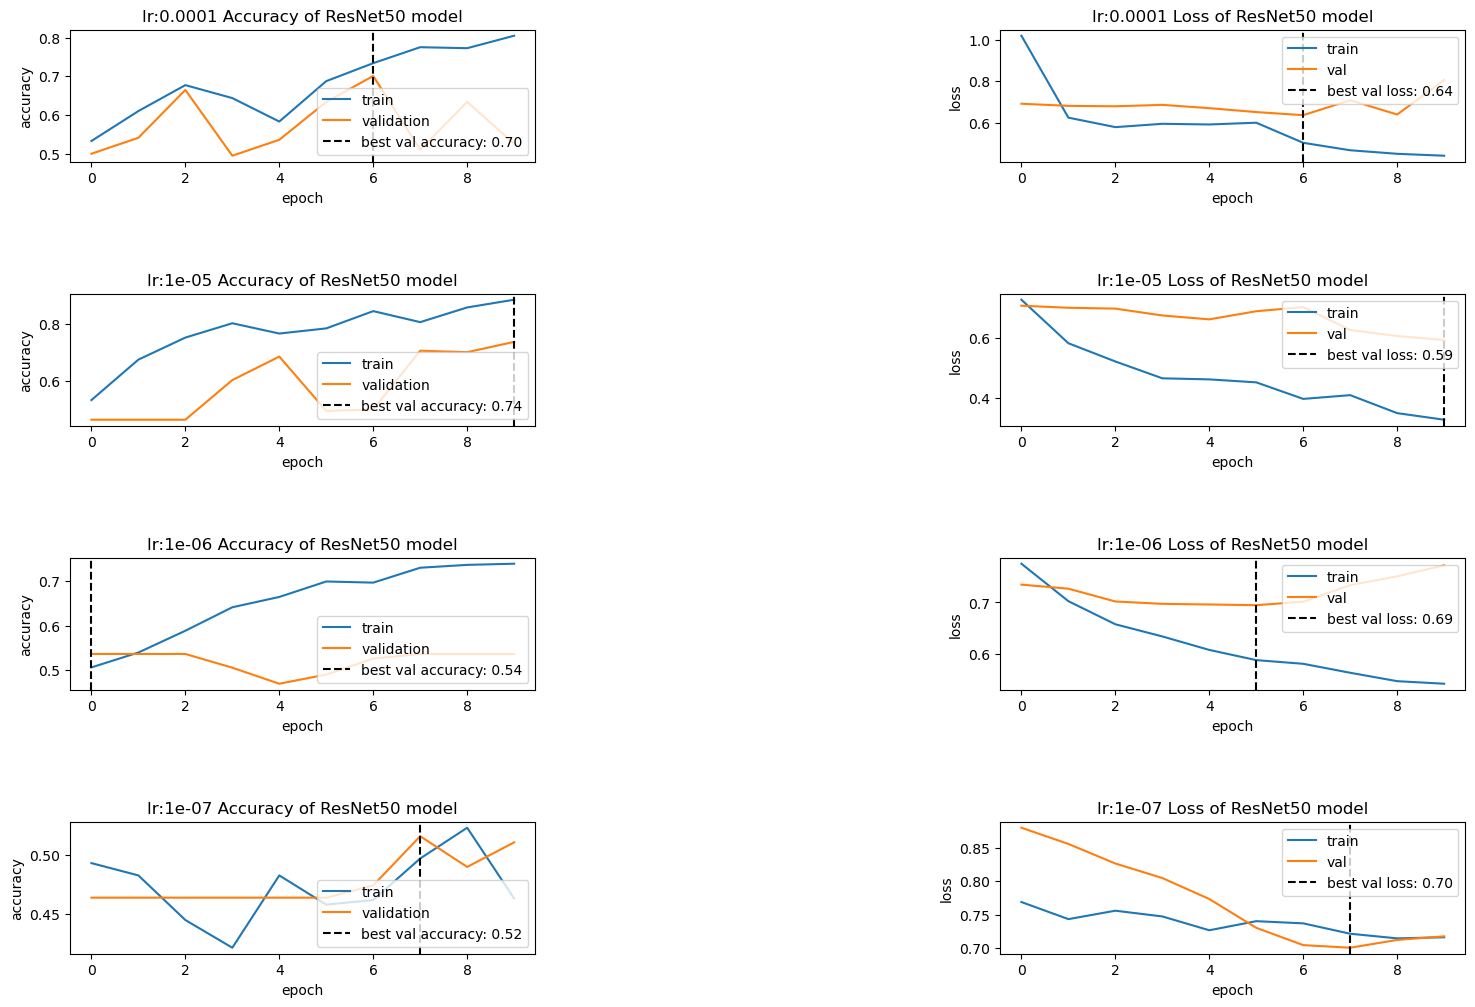

In [138]:
#plot the result - ResNet w/ learning rate
fig, axs = plt.subplots(4, 2, figsize=(18,12))
axs = axs.flatten()
for i, history in enumerate(history_list_lr):
    plot_helper_accuracy_models(history, 
                         title=f'lr:{learning_rates[i]} Accuracy of ResNet50 model', 
                         ax=axs[i*2])
    plot_helper_loss_models(history, 
                     title=f'lr:{learning_rates[i]} Loss of ResNet50 model', 
                     ax=axs[i*2+1])
plt.subplots_adjust(wspace=1, hspace=1)
plt.show()


learning rate = 1e-5 shows the most consistent increased in training and validation accuracy and decrease in training and testing loss

Epoch 1/10
25/25 [==============================] - 10s 182ms/step - loss: 0.7077 - accuracy: 0.5587 - val_loss: 0.7579 - val_accuracy: 0.4639
Epoch 2/10
25/25 [==============================] - 3s 120ms/step - loss: 0.5678 - accuracy: 0.7032 - val_loss: 0.7479 - val_accuracy: 0.4639
Epoch 3/10
25/25 [==============================] - 3s 120ms/step - loss: 0.5241 - accuracy: 0.7497 - val_loss: 0.7532 - val_accuracy: 0.4639
Epoch 4/10
25/25 [==============================] - 3s 119ms/step - loss: 0.4798 - accuracy: 0.7690 - val_loss: 0.7446 - val_accuracy: 0.4639
Epoch 5/10
25/25 [==============================] - 3s 120ms/step - loss: 0.4611 - accuracy: 0.7987 - val_loss: 0.7431 - val_accuracy: 0.4639
Epoch 6/10
25/25 [==============================] - 3s 120ms/step - loss: 0.4189 - accuracy: 0.8129 - val_loss: 0.7123 - val_accuracy: 0.4691
Epoch 7/10
25/25 [==============================] - 3s 115ms/step - loss: 0.4414 - accuracy: 0.7794 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch

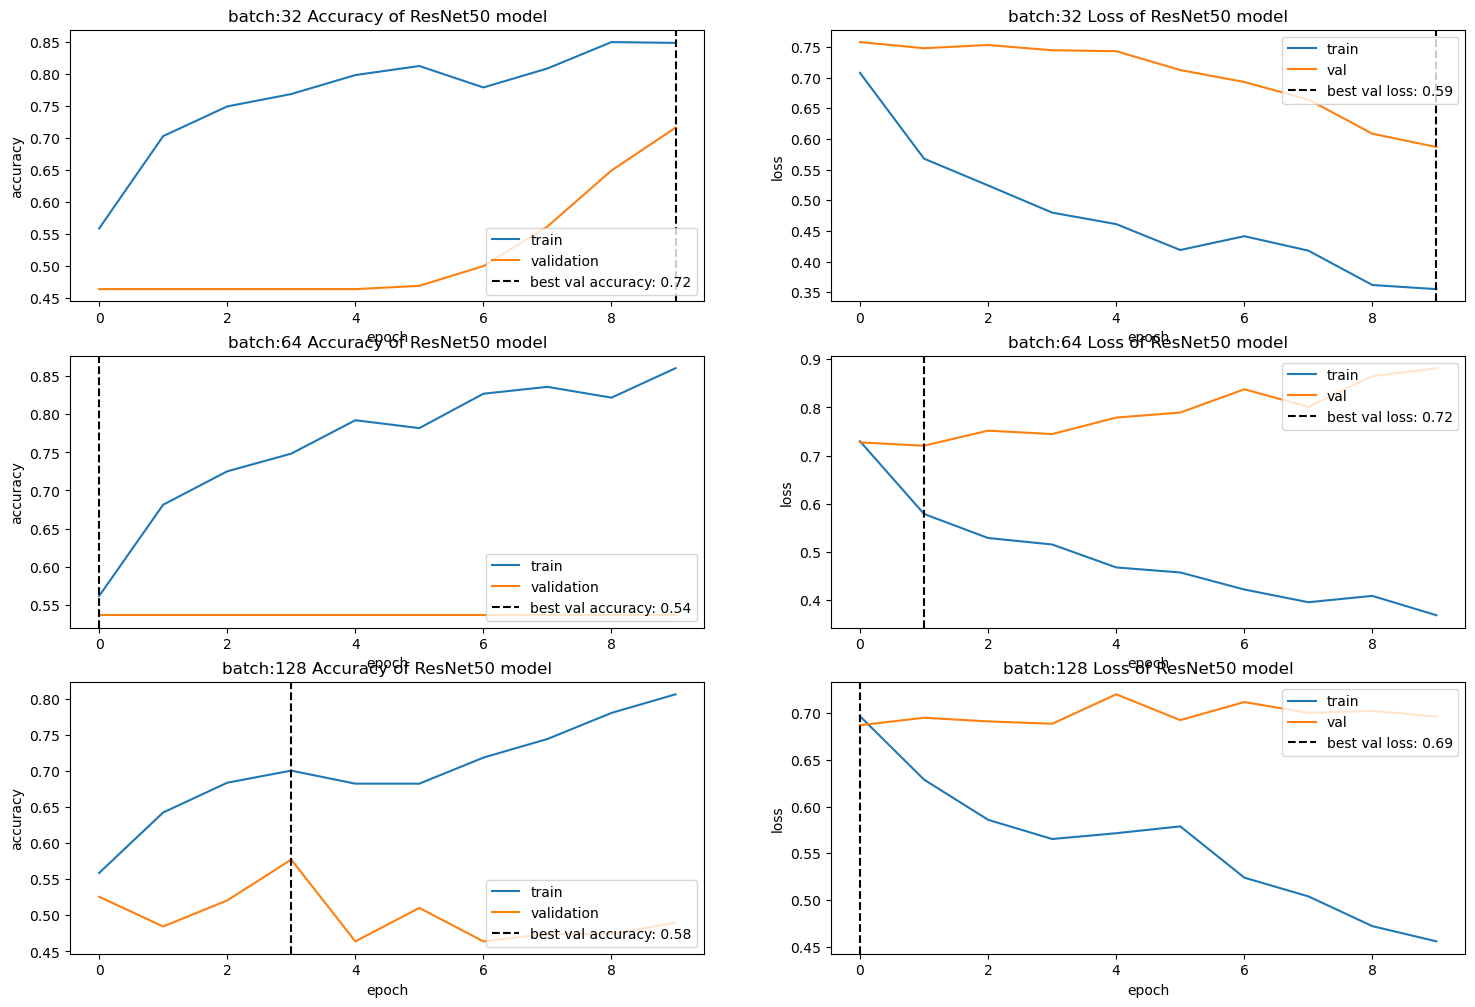

In [145]:
################################################################################
# RUN ResNet (hypeparameter tuning: batch size)
################################################################################
# Test batch size
batch_sizes = [32, 64, 128]
model_list_batch = []
history_list_batch = []
for batch in batch_sizes:
    model_batch = create_resnet_model(X_train_expand.shape[1:])
    history = compile_and_train_resnet_model(model_batch, Adam, 1e-5, batch, X_train_expand_part, y_train_part, X_val, y_val, 10) # use best learning rate
    model_list_batch.append(model_batch)
    history_list_batch.append(history)

# plot the result
fig, axs = plt.subplots(3, 2, figsize=(18,12))
axs = axs.flatten()
for i, history in enumerate(history_list_batch):
    plot_helper_accuracy_models(history, 
                         title=f'batch:{batch_sizes[i]} Accuracy of ResNet50 model', 
                         ax=axs[i*2])
    plot_helper_loss_models(history, 
                     title=f'batch:{batch_sizes[i]} Loss of ResNet50 model', 
                     ax=axs[i*2+1])

Batch size = 32 shows the most consistent increased in training and validation accuracy and decrease in training and testing loss

In [ ]:
################################################################################
# RUN ResNet (hypeparameter tuning: optimizers)
################################################################################
# Test different optimizers
optimizers = [Adam, RMSprop, SGD, Adagrad, Adadelta, Adamax]
model_list_opt = []
history_list_opt = []
for optimizer in optimizers:
    model_opt = create_resnet_model(X_train_expand.shape[1:])
    history = compile_and_train_resnet_model(model_opt, optimizer, 1e-5, 32, X_train_expand_part, y_train_part, X_val, y_val, 10)
    model_list_opt.append(model_opt)
    history_list_opt.append(history)

#plot the results
fig, axs = plt.subplots(6, 2, figsize=(18,12))
axs = axs.flatten()
for i, history in enumerate(history_list_opt):
    plot_helper_accuracy_models(history, 
                         title=f'{optimizers[i].__name__} Accuracy of ResNet50 model', 
                         ax=axs[i*2])
    plot_helper_loss_models(history, 
                     title=f'{optimizers[i].__name__} Loss of ResNet50 model', 
                     ax=axs[i*2+1])
plt.subplots_adjust(wspace=1, hspace=1)
plt.show()


Adam shows the most consistent increased in training and validation accuracy and decrease in training and testing loss

In [148]:
################################################################################
# FINAL ResNet AFTER HYPERPARAMETER TUNING
## Best learning rate = 1e-5 and batch_size = 32 from experimenting 
################################################################################
# Train on whole training set and test on test set 
resnet_model = create_resnet_model(input_shape=X_train_expand.shape[1:])

history_resnet = compile_and_train_resnet_model(model=resnet_model, optimizer=Adam, learning_rate=1e-5, batch_size=32, 
                                                X_train=X_train_expand, y_train=y_train, X_test=X_test_expand, y_test=y_test, epochs=50) 

Epoch 1/50
31/31 [==============================] - 13s 241ms/step - loss: 0.6622 - accuracy: 0.6120 - val_loss: 0.8064 - val_accuracy: 0.5000
Epoch 2/50
31/31 [==============================] - 5s 171ms/step - loss: 0.5756 - accuracy: 0.6873 - val_loss: 0.8238 - val_accuracy: 0.5000
Epoch 3/50
31/31 [==============================] - 5s 172ms/step - loss: 0.4895 - accuracy: 0.7575 - val_loss: 0.7979 - val_accuracy: 0.5000
Epoch 4/50
31/31 [==============================] - 5s 172ms/step - loss: 0.4651 - accuracy: 0.7843 - val_loss: 0.7602 - val_accuracy: 0.5000
Epoch 5/50
31/31 [==============================] - 5s 172ms/step - loss: 0.4286 - accuracy: 0.7988 - val_loss: 0.7278 - val_accuracy: 0.4977
Epoch 6/50
31/31 [==============================] - 5s 172ms/step - loss: 0.4208 - accuracy: 0.8194 - val_loss: 0.7324 - val_accuracy: 0.4965
Epoch 7/50
31/31 [==============================] - 5s 173ms/step - loss: 0.4071 - accuracy: 0.8122 - val_loss: 0.7615 - val_accuracy: 0.4965
Epoch

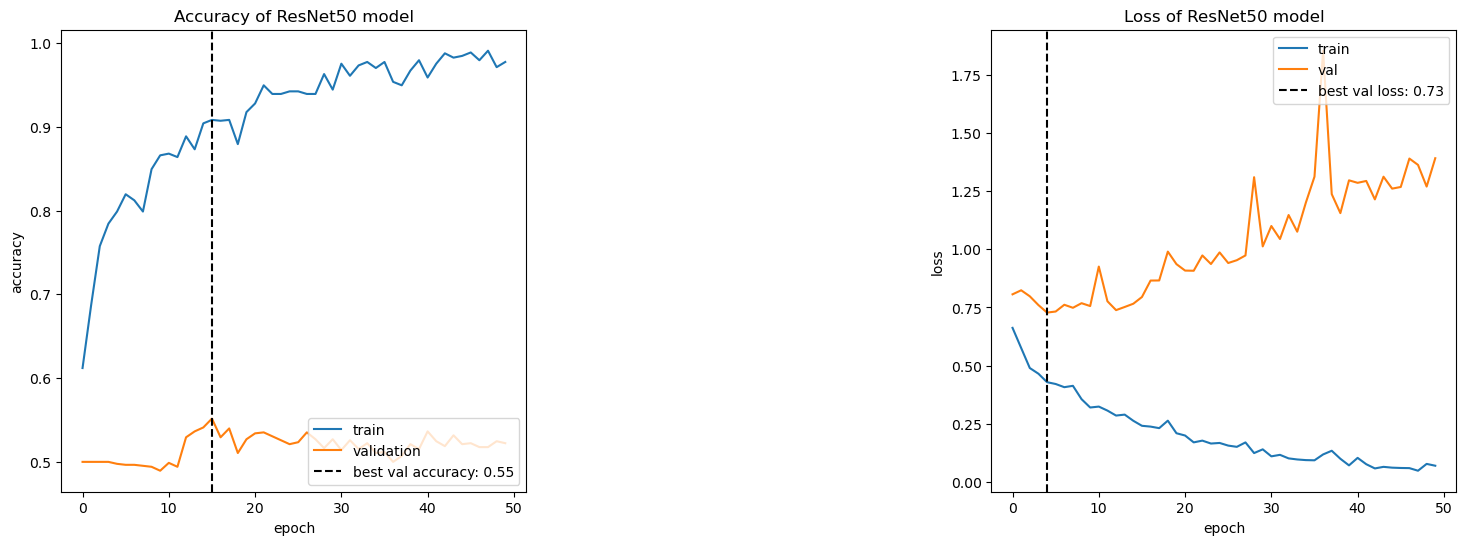

In [149]:
#plot the results
fig, axs = plt.subplots(1, 2, figsize=(18,6))
axs = axs.flatten()
plot_helper_accuracy(resnet_model, 
                         title=f'Accuracy of ResNet50 model', 
                         ax=axs[0])
plot_helper_loss(resnet_model,
                        title=f'Loss of ResNet50 model', 
                        ax=axs[1])
plt.subplots_adjust(wspace=1, hspace=1)
plt.show()

<a id="final_model"></a>
# 5. Final Model Pipeline Setup

<div style="background: #f5f5dc; border: thin solid black; padding: 5px">

Tentative pipeline for the next milestone's final model (from data preprocessing to evaluation)

- Decompress the 100+GB of data and turn into png/jpeg for image to be reasonable size.
- Preprocess the images locally into numpy arrays, upload processed numpy arrays into google drive for further analysis. The images will have been processed to address the distribution shift.
- Under the constraint of limited GPUs on jupyter hub, further fine-tune the ResNet model to improve performance. 
- Add another transfer learning model for images to test its performance against ResNet.
- Consult the teaching staff for possible GPU resources as we couldn't train much with jupyter hub and google colab.
- Evaluate the model performance with accuracy and AUROC.
- Add interpretability to understand the traits the models is learning. Specifically, using Grad-CAM to see the key pixels may help provide insights into the generalizability of the model.

<b>Not described in here but in the problem description:
assumptions, 
parameter choices, 
preliminary tuning considerations

"Outline steps for a pipeline for your final model, describing each component from data preprocessing to evaluation. 
Document assumptions, parameter choices, and preliminary tuning considerations." </b>